In [1]:
# Import oh so many libraries
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

%matplotlib inline

In [61]:
make_cov = lambda  theta: np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

theta_vec = (10, 5, 1, 0)
theta1, theta2, theta3, theta4 = theta_vec

# define gaussian mixture 1 
cov1 = make_cov(theta1)
sigma1 = np.array([[2, 0],[0, 1]])
mvn1 = scipy.stats.multivariate_normal([12, 7], cov=cov1@sigma1@cov1.T)

# gaussian mixture 2
cov2 = make_cov(theta2)
sigma2 = np.array([[2, 0],[0, 2]])
mvn2 = scipy.stats.multivariate_normal([0, 11], cov=cov2@sigma2@cov2.T)

# gaussian mixture 3
cov3 = make_cov(theta3)
sigma3 = np.array([[.5, 0],[0, 1]])
mvn3 = scipy.stats.multivariate_normal([2.5, 2.5], cov=cov3@sigma3@cov3.T)

# gaussian mixture 4
cov4 = make_cov(theta4)
sigma4 = np.array([[.2, 0],[0, 1]])
mvn4 = scipy.stats.multivariate_normal([7.5, -1], cov=cov4@sigma4@cov4.T)

f = lambda xvec: mvn1.pdf(xvec) + mvn2.pdf(xvec) + .5*mvn3.pdf(xvec) + .2*mvn4.pdf(xvec)

p = lambda x, y: f([x,y])

In [76]:
# create grid for plotting
xlim, ylim = (-5,16), (-5,16)

x = np.linspace(xlim[0], xlim[1],1000)
y = np.linspace(ylim[0], ylim[1],1000)
z = np.zeros(1000)

# reshape grid for contour plot and for generating p(x,y) values
X, Y = np.meshgrid(x,y)
X_grid = np.c_[np.ravel(X), np.ravel(Y)]
Z = f(X_grid)
Z = Z.reshape(X.shape)

In [77]:
# define function for plotting contours, used again later in notebook

def plot_contours(title, ax, contours=[X,Y,Z], color_bar=False, x_name="$x$", y_name="$y$", fs=15):
    
    surface = ax.contourf(*contours, 40, cmap="viridis")
    ax.contour(*contours, colors="white", alpha=0.4)

    if color_bar:
        cbar = plt.colorbar(surface, shrink=1, aspect=15)
        cbar.ax.set_ylabel('\n$p(x,y)$', fontsize=fs)
    
    ax.set_title(title, fontsize=fs)
    ax.set_xlabel(x_name, fontsize=fs)
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs-3)
    ax.set_ylabel(y_name, fontsize=fs)
    ax.grid(linestyle=":")

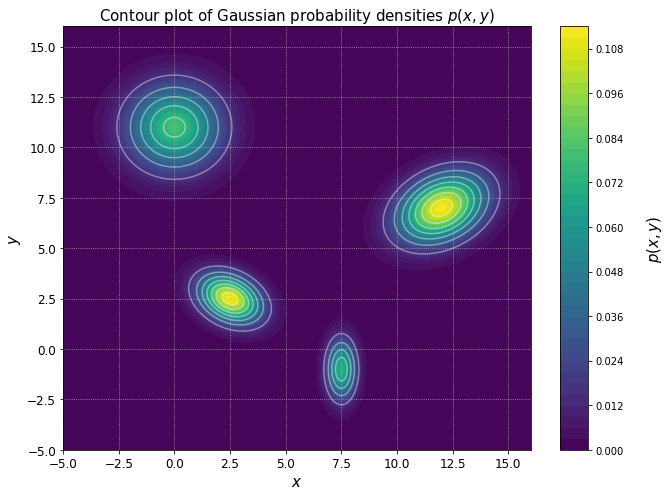

In [78]:
title = "Contour plot of Gaussian probability densities $p(x,y)$"

fig, ax = plt.subplots(figsize=(9.5,7))

plot_contours(title, ax, contours=[X,Y,Z], color_bar=True, x_name="$x$", y_name="$y$", fs=15)

plt.tight_layout()
plt.show()

# Attempt to sample with metropolis

In [71]:
# define basic metropolis sampling function

def metropolis(p, qdraw, xinit, nsamp=10000):
    samples=np.empty((nsamp,2))
    x_prev = xinit
    accepted = 0
    for i in tqdm.tqdm(range(nsamp), position=0):
        x_star = qdraw(x_prev)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star / p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples[i] = x_star
            x_prev = x_star
            accepted += 1
        else:
            samples[i]= x_prev
            
    return samples, accepted

In [72]:
nsamp = 20000
# burnin = 1000
# thinning = 1

cov = np.array(([1,0],[0,1]))
qdraw = lambda x: scipy.stats.multivariate_normal.rvs(mean=[0, 0], 
                                                      cov=cov)+x

start = [15,-2] # initialize the sampler outside of the three Gaussian peaks 

M_samples, M_accepted = metropolis(f, qdraw, start, nsamp=nsamp)

100%|██████████| 20000/20000 [00:05<00:00, 3527.26it/s]


In [80]:
# Define plotting functions to compare sampling results
# these include Pathplot, 2D-Histogram, Marginal-Histograms, Traceplots, and Autocorrelation plots

def plot_path_hist(samples, title_1, title_2, burnin=0, thinning=1, bins=100, 
                   contour=[X,Y,Z], x_name="$x$", y_name="$y$", fs=15):
    
    thinning=1
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13.25, 6), sharey=True, sharex=True)
    
    ax1.plot(samples[::thinning,0], samples[::thinning,1], 
             alpha=0.8, linewidth=0.4, label="sampling path")
    ax1.plot(samples[0,0], samples[0,1], "ko", alpha=1, label="start point")
    ax1.plot(samples[-1,0], samples[-1,1], "k^", alpha=1, label="end point")
    ax1.contour(*contour, colors="k", alpha=0.4)
    ax1.set_title(title_1, fontsize=fs)
    ax1.set_xlabel(x_name, fontsize=fs)
    ax1.set_ylabel(y_name, fontsize=fs)
    ax1.set_xlim(xlim[0],xlim[1])
    ax1.set_ylim(ylim[0],ylim[1])
    ax1.grid(linestyle=":")
    ax1.legend()
    
    my_cmap = plt.cm.Blues
    my_cmap.set_under('w',1)
    
    ax2.hist2d(samples[burnin::thinning,0], samples[burnin::thinning,1], cmin=0.0001, bins=bins, 
               normed=True, cmap="Blues")
    ax2.contour(*contour, colors="k", alpha=0.4)
    ax2.set_title(title_2, fontsize=fs)
    ax2.set_xlabel(x_name, fontsize=fs)
    ax2.set_xlim(xlim[0],xlim[1])
    ax2.set_ylim(ylim[0],ylim[1])
    ax2.grid(linestyle=":")
    
    plt.tight_layout()
    plt.show()
    
def plot_marginals(samples, dist_name, burnin=0, thinning=1, 
                   x_name="$x$", y_name="$y$", width=13.25, height=3, 
                   bins=100, fs=15, title_custom=False):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(width, height), sharey=True)

    ax1.hist(samples[burnin::thinning,0], bins=bins, density=True, alpha=0.4)
    if title_custom==False:
        ax1.set_title("{0} marginal distribution of sampled {1}".format(x_name, dist_name), fontsize=fs)
    else:
        ax1.set_title(title_custom.format(x_name, dist_name), fontsize=fs)
    ax1.grid(linestyle=":")
    ax1.set_xlabel("{0}".format(x_name), fontsize=fs)
    ax1.set_ylabel("normed frequency", fontsize=fs)
    ax1.set_xlim(xlim[0],xlim[1])

    ax2.hist(samples[burnin::thinning,1], bins=bins, density=True, alpha=0.4)
    if title_custom==False:
        ax2.set_title("{0} marginal distribution of sampled {1}".format(y_name, dist_name), fontsize=fs)
    else:
        ax2.set_title(title_custom.format(y_name, dist_name), fontsize=fs)
    ax2.grid(linestyle=":")
    ax2.set_xlim(ylim[0],ylim[1])
    ax2.set_xlabel("{0}".format(y_name), fontsize=fs)

    plt.tight_layout()
    plt.show()

# Define functions for generating traceplots and autocorrelation plots
# These functions are used repeatedly throughout this notebook.

def traceplot(data, burnin=0, thin=1, var_names=["x", "y"]):
    
    fs = 15
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.25,3))
    
    ax1.plot(data[burnin::thin,0], alpha=0.4)
    ax1.set_title("Traceplot of {0} marginal samples".format(var_names[0]), fontsize=fs)
    ax1.grid(linestyle=":")
    ax1.set_xlabel("sample", fontsize=fs-2)
    ax1.set_ylabel(var_names[0], fontsize=fs)
    
    ax2.plot(data[burnin::thin,1], alpha=0.4)
    ax2.set_title("Traceplot of {0} marginal samples".format(var_names[1]), fontsize=fs)
    ax2.grid(linestyle=":")
    ax2.set_xlabel("sample", fontsize=fs-2)
    ax2.set_ylabel(var_names[1], fontsize=fs)
    
    plt.tight_layout()
    plt.show()

def corrplot(data, burnin=0, thin=1, maxlags=50, var_names=["x", "y"]):
    fs = 15
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.25,3))
    
    ax1.acorr(data[burnin::thin,0]-np.mean(data[burnin::thin,0]), 
              normed=True, maxlags=maxlags);
    ax1.set_xlim([0, maxlags])
    ax1.set_title("Autocorrelation of {0} marginal samples".format(var_names[0]), fontsize=fs)
    ax1.grid(linestyle=":")
    ax1.set_xlabel("lag", fontsize=fs-2)
    ax1.set_ylabel("correlation", fontsize=fs)
    
    ax2.acorr(data[burnin::thin,1]-np.mean(data[burnin::thin,1]), 
              normed=True, maxlags=maxlags);
    ax2.set_xlim([0, maxlags])
    ax2.set_title("Autocorrelation of {0} marginal samples".format(var_names[1]), fontsize=fs)
    ax2.grid(linestyle=":")
    ax2.set_xlabel("lag", fontsize=fs-2)
    ax2.set_ylabel("correlation", fontsize=fs)
    
    plt.tight_layout()
    plt.show()

In [81]:
def plot_title(title, width=16, height=0.5, fs=18):
    plt.figure(figsize=(16, 0.5)) 
    plt.axis('off')
    plt.text(0.5, 0.5, title,
             ha='center',va='center', fontsize=fs)
    plt.show()

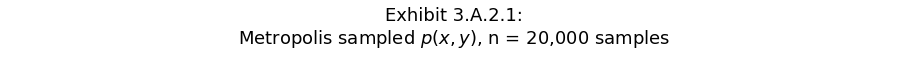

/home/sedelmeyer/Code/tempering-annealing/env/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.


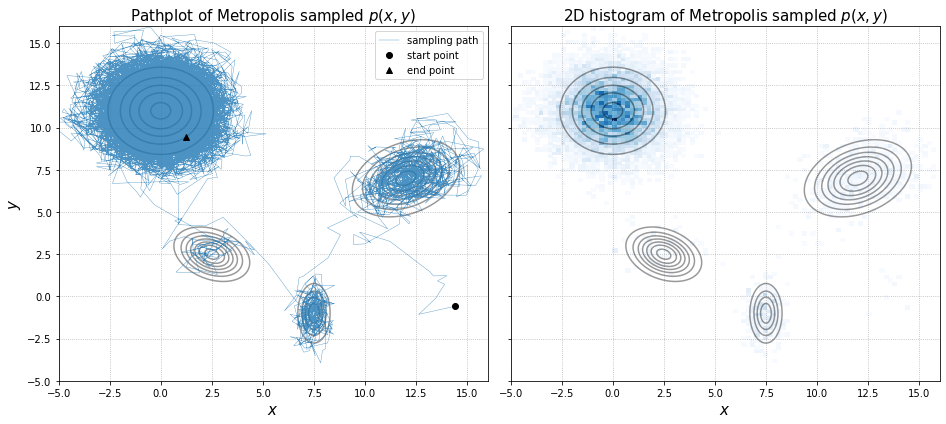

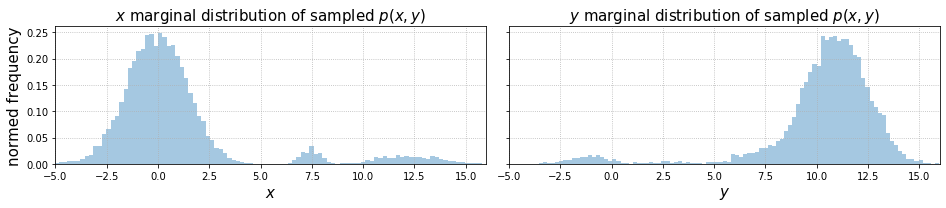

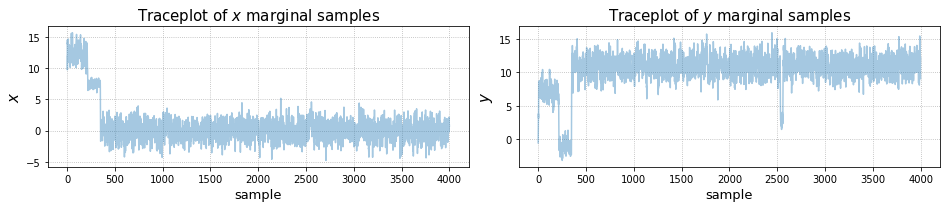

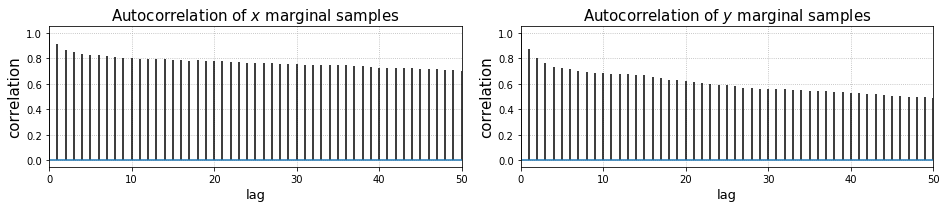

In [82]:
# plot results
title = "Exhibit 3.A.2.1:\nMetropolis sampled $p(x,y)$, n = {0:,} samples".format(nsamp)
    
plot_title(title)

title_1 = "Pathplot of Metropolis sampled $p(x,y)$"
title_2 = "2D histogram of Metropolis sampled $p(x,y)$"

plot_path_hist(M_samples, title_1, title_2, contour=[X,Y,Z])

plot_marginals(M_samples, dist_name="$p(x,y)$", burnin=0, thinning=1, 
               x_name="$x$", y_name="$y$")

traceplot(M_samples, burnin=0, thin=5, var_names=["$x$", "$y$"])
corrplot(M_samples, burnin=0, thin=5, var_names=["$x$", "$y$"])